# Feature Engineering

- One of the more important steps in using machine learning in practice is *feature engineering*: that is, taking whatever information you have about your problem and turning it into numbers that you can use to build your feature matrix.

### Categorical Features

- Here is some example housing prices.

In [1]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

- You might be tempted to encode non-numerical data with a numerical map:

In [2]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

- This is not a useful approach in Scikit-Learn: the package's models assume that numerical features reflect algebraic quantities. Such a map would imply, *Queen Anne < Fremont < Wallingford*, or *Wallingford - Queen Anne = Fremont*, which doesn't make much sense.
- Let's use *one-hot encoding* instead. It creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively. If your data is a list of dictionaries, Scikit-Learn's ``DictVectorizer`` will do this for you.

In [3]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]], dtype=int64)

- The 'neighborhood' column is expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood. Now we can proceed with fitting the model.
- To see the meaning of each column, you can inspect the feature names:

In [4]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

- If your category has many possible values, this can *greatly* increase the size of your dataset. Because encoded data contains mostly zeros, a sparse output can be much more efficient.

In [5]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

- Most Scikit-Learn estimators accept sparse inputs. ``sklearn.preprocessing.OneHotEncoder`` and ``sklearn.feature_extraction.FeatureHasher`` are two additional tools to support one-shot encoding.

### Text Features

- Another common problem is converting text to a set of representative numerical values. For example, most automatic mining of social media data relies on some form of encoding the text as numbers.
- One method of encoding text data uses *word counts*: you take each snippet of text, count the occurrences of each word within it, and put the results in a table. Scikit-Learn's ``CountVectorizer`` does this.

In [6]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

For a vectorization of this data based on word count, we could construct a column representing the word "problem," the word "evil," the word "horizon," and so on.
While doing this by hand would be possible, the tedium can be avoided by using Scikit-Learn's ``CountVectorizer``:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

- It is easier to inspect if we convert this to a ``DataFrame`` with labeled columns:

In [8]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


- Raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms.
- Let's use *term frequency-inverse document frequency* (*TF–IDF*) to fix this problem. It weights the word counts by a measure of how often they appear in the documents.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


### Image Features

- Another common need is the need to encode *images*. The simplest approach is to simply use the pixel values themselves. But this approach may not be optimal.
- You can find examples of many standard approaches in the [Scikit-Image project](http://scikit-image.org). Stay tuned, we'll cover this in a later section.

### Derived Features

- Another type of feature is one that is derived from input features. We saw an example when we constructed *polynomial features* from our input data. We saw that we could convert a linear regression into a polynomial regression not by changing the model, but by transforming the input! This is sometimes known as *basis function regression*.
- For example, this data clearly cannot be well described by a straight line:

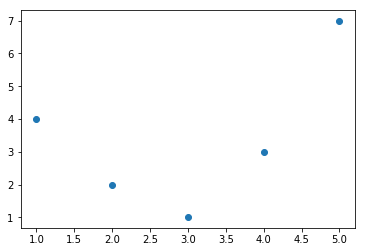

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

- Still, we can fit a line to the data using ``LinearRegression`` and get the optimal result:

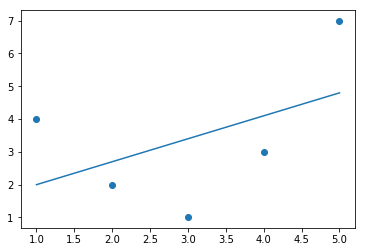

In [11]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

- It's clear that we need a more sophisticated model to describe the relationship between $x$ and $y$.
- One approach is to transform the data, adding extra columns of features to drive more flexibility in the model.

In [12]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[   1.    1.    1.]
 [   2.    4.    8.]
 [   3.    9.   27.]
 [   4.   16.   64.]
 [   5.   25.  125.]]


- The derived feature matrix has one column representing $x$, a second column representing $x^2$, and a third column representing $x^3$.
- A linear regression on this expanded input gives a much closer fit to our data:

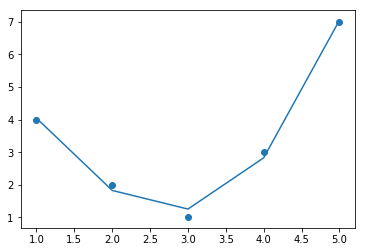

In [13]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

- This idea of improving a model not by changing the model, but by transforming the inputs, is fundamental to many of the more powerful machine learning methods.

### Imputation of Missing Data

In [14]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

- When applying a machine learning model, we need to replace such missing data with some appropriate fill value. This is known as *imputation*, and strategies range from simple (e.g., replacing missing values with the mean of the column) to sophisticated (e.g., using matrix completion or a robust model to handle such data).
- The sophisticated approaches tend to be very application-specific, and we won't dive into them here.
- Scikit-Learn provides the ``Imputer`` class for baseline approaches using the mean, median, or most frequent value.

In [15]:
from sklearn.preprocessing import Imputer
imp = Imputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[ 4.5,  0. ,  3. ],
       [ 3. ,  7. ,  9. ],
       [ 3. ,  5. ,  2. ],
       [ 4. ,  5. ,  6. ],
       [ 8. ,  8. ,  1. ]])

- The two missing values have been replaced with the mean of the remaining values in the column. This imputed data can be fed directly into, for example, a ``LinearRegression`` estimator:

In [16]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([ 13.14869292,  14.3784627 ,  -1.15539732,  10.96606197,  -5.33782027])

### Feature Pipelines

- Manual transformations are just tedious, especially when you string together multiple steps. Here is an example processing pipeline.

    1. Impute missing values using the mean
    2. Transform features to quadratic
    3. Fit a linear regression

- Use a Scikit-Learn ``Pipeline`` object to streamline this process.

In [17]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(Imputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

- Apply this pipeline to your input data.

In [18]:
model.fit(X, y)  # X with missing values, from above
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[ 14.  16.  -1.   8.  -5.]
